In [1]:
import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
from itertools import chain

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 28})

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/cmantill/LDMX/ldmxsw/ldmx-helpers/data/kaon_pn_4GeV_Jul27_ntuple/*.root")

In [3]:
def pz_smear(pz):
    pz_array = []
    for part in pz:
        for element in part:
            if element <= 50:
                pz_perc = random.gauss(1,0.0404);
            elif element <= 100: 
                pz_perc = random.gauss(1,0.0410);
            elif element <= 250: 
                pz_perc = random.gauss(1,0.0415);
            elif element <= 500: 
                pz_perc = random.gauss(1,0.0420);
            elif element <= 1000: 
                pz_perc = random.gauss(1,0.0435);
            elif element <= 2000:  
                pz_perc = random.gauss(1,0.0477);
            elif element <= 3000:  
                pz_perc = random.gauss(1,0.0523);
            elif element <= 4000:  
                pz_perc = random.gauss(1,0.0573);            
            else:    
                pz_perc = random.gauss(1,0.06);
            pz_array=np.append(pz_array, [pz_perc])
    return (pz_array)

def px_smear(p):
    px_array = []
    for part in p:
        for element in part:
            if element <= 100:
                px_uncer = random.gauss(0,3.00);
            elif element <= 400: 
                px_uncer = random.gauss(0,3.20);
            elif element <= 500: 
                px_uncer = random.gauss(0,3.20);
            elif element <= 1000: 
                px_uncer = random.gauss(0,3.40);
            elif element <= 1300: 
                px_uncer = random.gauss(0,3.50);
            elif element <= 2000:  
                px_uncer = random.gauss(0,3.85);           
            else:    
                px_uncer = random.gauss(0,3.85);
            px_array=np.append(px_array, [px_uncer])
    return (px_array)

def py_smear(p):
    py_array = []
    for part in p:
        for element in part:
            if element <= 100:
                py_uncer = random.gauss(0,3.75);
            elif element <= 350: 
                py_uncer = random.gauss(0,3.80);
            elif element <= 500: 
                py_uncer = random.gauss(0,4.20);
            elif element <= 1000: 
                py_uncer = random.gauss(0,4.80);
            elif element <= 1200: 
                py_uncer = random.gauss(0,4.98);
            elif element <= 2000:  
                py_uncer = random.gauss(0,3.85);           
            else:    
                py_uncer = random.gauss(0,5.50);
            py_array=np.append(py_array, [py_uncer])
    return (py_array)

In [4]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_PNParticle']
    sim_particle_n = ldmx_events['n']['Sim_PNParticle']
    sim_particle_dau1 = ldmx_events['Sim_PNParticle_dau1']
    sim_particle_dau2 = ldmx_events['Sim_PNParticle_dau2']
    
    pi_mass = 139.57039
    kaon_mass = 493.677
    
    decay_num_mask = sim_particle_dau2.momdecay == 2
    decay2_mask = abs(sim_particle_dau2.pdgID) == 211
    decay_mask = decay_num_mask & decay2_mask
    
    dau1 = get_vector(sim_particle_dau1[decay_mask])
    dau2 = get_vector(sim_particle_dau2[decay_mask])
    dausum = (dau1 + dau2)
    
    theta1_mask = (dau1.theta*180/math.pi <= 40)
    theta2_mask = (dau2.theta*180/math.pi <= 40)
    theta_mask = theta1_mask & theta2_mask
        
    n_pdgID_mask   = sim_particle[decay_mask].pdgID == 310    
    new_pdgID_mask = sim_particle[decay_mask][theta_mask].pdgID == 310
    
    n_px1 = px_smear(dau1.p)+flat(dau1.px)
    n_px2 = px_smear(dau2.p)+flat(dau2.px)
    n_py1 = py_smear(dau1.p)+flat(dau1.py)
    n_py2 = py_smear(dau2.p)+flat(dau2.py)
    n_pz1 = pz_smear(dau1.pz)*flat(dau1.pz)
    n_pz2 = pz_smear(dau2.pz)*flat(dau2.pz)
    n_psq1= n_px1**2+n_py1**2+n_pz1**2
    n_psq2= n_px2**2+n_py2**2+n_pz2**2
    n_e1 = (np.sqrt(n_psq1+pi_mass**2))
    n_e2 = (np.sqrt(n_psq2+pi_mass**2))
    
    new_px1 = px_smear(dau1[theta_mask].p)+flat(dau1[theta_mask].px)
    new_px2 = px_smear(dau2[theta_mask].p)+flat(dau2[theta_mask].px)
    new_py1 = py_smear(dau1[theta_mask].p)+flat(dau1[theta_mask].py)
    new_py2 = py_smear(dau2[theta_mask].p)+flat(dau2[theta_mask].py)
    new_pz1 = pz_smear(dau1[theta_mask].pz)*flat(dau1[theta_mask].pz)
    new_pz2 = pz_smear(dau2[theta_mask].pz)*flat(dau2[theta_mask].pz)
    new_psq1 = new_px1**2+new_py1**2+new_pz1**2
    new_psq2 = new_px2**2+new_py2**2+new_pz2**2
    new_e1 = (np.sqrt(new_psq1+pi_mass**2))
    new_e2 = (np.sqrt(new_psq2+pi_mass**2))
    
    
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    dau1_smear =  ak.zip({"x": n_px1,
                    "y": n_py1,
                    "z": n_pz1,
                    "t": n_e1,
                    },
                    with_name="LorentzVector")
    dau2_smear =  ak.zip({"x": n_px2,
                    "y": n_py2,
                    "z": n_pz2,
                    "t": n_e2,
                    },
                    with_name="LorentzVector")
    dausum_smear = dau1_smear + dau2_smear
    
    dau1_smeared =  ak.zip({"x": new_px1,
                    "y": new_py1,
                    "z": new_pz1,
                    "t": new_e1,
                    },
                    with_name="LorentzVector")
    dau2_smeared =  ak.zip({"x": new_px2,
                    "y": new_py2,
                    "z": new_pz2,
                    "t": new_e2,
                    },
                    with_name="LorentzVector")
    dausum_smeared = dau1_smeared + dau2_smeared
    
    hists["rec"].fill(
        rec = "theta",
        k = flat(dausum_smeared.t)-kaon_mass,
        e = flat(sim_particle_dau2[decay_mask][theta_mask].electrone)
    )
    hists["rec"].fill(
        rec = "all",
        k = flat(dausum_smear.t)-kaon_mass,
        e = flat(sim_particle_dau2[decay_mask].electrone),
    ) 
    

In [11]:
kine_bins = np.array(list(range(0,1500,100))+list(range(1500,3100,250)))
print(kine_bins)

[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1750 2000 2250 2500 2750 3000]


In [6]:
hists = {}

kine_bins = np.array(list(range(0,1500,100))+list(range(1500,3100,250)))
hists["rec"] = hist.Hist(
    hist.axis.StrCategory([], name="rec", growth=True),
    #hist.axis.Regular(30, 0, 3000, name='k', label=r'$K_S$ Rec Kinetic Energy [MeV]'),
    hist.axis.Variable(kine_bins, name='k', label=r'$K_S$ Rec Kinetic Energy [MeV]'),
    hist.axis.Regular(30, 0, 1500, name='e', label=r"Recoil Electron Energy [MeV]"),
)

nchunk = 0
for chunk in ldmx_dict:
    nchunk += 1
    print('process', nchunk)
    #if nchunk>150: break
    ProcessChunk(chunk, hists)


process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
process 15
process 16
process 17
process 18
process 19
process 20
process 21
process 22
process 23
process 24
process 25
process 26
process 27
process 28
process 29
process 30
process 31
process 32
process 33
process 34
process 35
process 36
process 37
process 38
process 39
process 40
process 41
process 42
process 43
process 44
process 45
process 46
process 47
process 48
process 49
process 50
process 51
process 52
process 53
process 54
process 55
process 56
process 57
process 58
process 59
process 60
process 61
process 62
process 63
process 64
process 65
process 66
process 67
process 68
process 69
process 70
process 71
process 72
process 73
process 74
process 75
process 76
process 77
process 78
process 79
process 80
process 81
process 82
process 83
process 84
process 85
process 86
process 87
process 88
process 89
process 90
process 91
process 

In [7]:
import pickle as pkl
with open('hists_kaon_wp.pkl', 'wb') as f:
    pkl.dump(hists, f)

In [2]:
import pickle as pkl
with open('hists_kaon_wp.pkl', 'rb') as f:
    hists = pkl.load(f)
    f.close()

In [4]:
hists['rec'][{'rec':'all'}].project('k')

Hist(Variable(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500., 1750., 2000.,
       2250., 2500., 2750., 3000.]), name='k', label='$K_S$ Rec Kinetic Energy [MeV]'), storage=Double()) # Sum: 97849.0 (98565.0 with flow)

[   0.    0.   57.  344.  754. 1241. 1620. 1760. 1847. 1866. 1744. 1642.
 1398. 1271. 1105. 2870. 2525. 1793. 1271.  891.  563.] [23457. 13108.  8996.  7259.  6030.  5252.  4714.  3871.  3307.  2867.
  2472.  2072.  1701.  1454.  1267.  2927.  2582.  1815.  1225.   885.
   588.]
[0.         0.         0.00633615 0.04738945 0.12504146 0.23629094
 0.34365719 0.45466288 0.55851225 0.65085455 0.70550162 0.79247104
 0.82186949 0.8741403  0.87213891 0.98052614 0.97792409 0.98787879
 1.         1.         0.95748299]
[[0.00000000e+00 0.00000000e+00 8.34774837e-04 2.49893878e-03
  4.27900126e-03 5.90546895e-03 6.98894103e-03 8.11944221e-03
  8.80278026e-03 9.12942146e-03 9.45334811e-03 9.29387402e-03
  9.76471185e-03 9.30921228e-03 1.00811366e-02 2.90309866e-03
  3.28598178e-03 3.14999057e-03 1.50174606e-03 2.07808822e-03
  1.00430909e-02]
 [7.84818775e-05 1.40440370e-04 9.51827465e-04 2.62707948e-03
  4.40577512e-03 6.00751084e-03 7.05628079e-03 8.14324049e-03
  8.76678037e-03 9.02214756e-03 

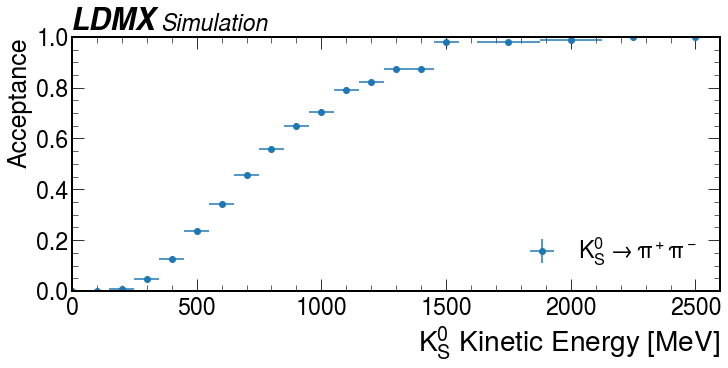

In [10]:
num = hists['rec'][{'rec':'theta'}].project('k')
den = hists['rec'][{'rec':'all'}].project('k')

n = num.values()
d = den.values()
print(n,d)
n[n>d] = d[n>d]

from hist.intervals import clopper_pearson_interval

print(n/d)
print(abs(clopper_pearson_interval(n,d) - n/d))
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
xerr = np.array([50]*16 + [125]*5)
print(xerr)
x    x=[num.axes.value(i)[0] for i in range(len(num.values()))],
    y=num.values()/den.values(),
    xerr=xerr,
    yerr=abs(clopper_pearson_interval(n,d) - n/d),
    fmt="o",
    label=r"$K_S^0\rightarrow \pi^+\pi^-$",
)
ax.set_xlim(0,2600)
ax.set_ylim(0,1)
ax.legend(loc='lower right')
ax.set_ylabel(r'Acceptanlce',fontsize=25)
ax.set_xlabel(r'$K_S^0$ Kinetic Energy [MeV]')
#hep.cms.lumitext(f"Simulation", ax=ax,**{"fontsize":30})
hep.cms.text(text="Simulation",loc=0,ax=ax,**{"exp":"LDMX","exp_weight":"bold","fontsize":23,"italic":(True,True)})
fig.savefig('kaon_kine.pdf')